# A MadMiner Example Analysis -  Analyzing dim6 operators in $W\gamma$ 

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.utils.particle import MadMinerParticle

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. 

**This needs to be updated by the user**

In [2]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 3. Extract Parton Level Observables / Weights with the LHE Processor

### 3a) Setting up the LHEProcessor

Here we extract the parton level information (observables and weights) from the .lhe file. This is done with the LHEProcessor package. 

In [3]:
lhep = LHEProcessor()

09:33  
09:33  ------------------------------------------------------------
09:33  |                                                          |
09:33  |  MadMiner v0.1.1                                         |
09:33  |                                                          |
09:33  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
09:33  |                                                          |
09:33  ------------------------------------------------------------
09:33  


After creating the object, one can add a number of LHE event samples. 

In [4]:
lhep.add_lhe_sample('mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark="sm")

09:33  Adding LHE sample at mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz


We also want to specify the Benchmark names, because sometimes the order is mixed up in the LHE files. But fortunately, we already stored them in the HDF5 file. 

In [5]:
lhep.read_benchmark_names('data/madminer_example.h5')

### 3b) Defining observables

We can now process the data and evaluate observables for each event. This is needed for example for plotting or to evaluate the Fisher Information in histograms of observables. 

Observables are also used for the MadMiner Machine Learning approach. Note that this requires a complete set of obseravbles that can encode the full kinematics of the event. Additionally, we have found that the Machine Learning performs better higher level observables (such as masses or angular differences between particles) than with the four momenta itself (pz, py, pz, E).

Observables can be any function of the fpr momenta. The `p[i]` correspond to the i'th parton momentum as specified when generating the process.  All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [6]:
lhep.add_observable('px_l', 'p[0].px')
lhep.add_observable('px_v', 'p[1].px')
lhep.add_observable('px_a', 'p[2].px')

lhep.add_observable('py_l', 'p[0].py')
lhep.add_observable('py_v', 'p[1].py')
lhep.add_observable('py_a', 'p[2].py')

lhep.add_observable('pz_l', 'p[0].pz')
lhep.add_observable('pz_v', 'p[1].pz')
lhep.add_observable('pz_a', 'p[2].pz')

lhep.add_observable('e_l', 'p[0].e')
lhep.add_observable('e_v', 'p[1].e')
lhep.add_observable('e_a', 'p[2].e')

lhep.add_observable('pt_l', 'p[0].pt')
lhep.add_observable('pt_v', 'p[1].pt')
lhep.add_observable('pt_a', 'p[2].pt')

lhep.add_observable('eta_l', 'p[0].eta')
lhep.add_observable('eta_v', 'p[1].eta')
lhep.add_observable('eta_a', 'p[2].eta')

lhep.add_observable('dphi_lv', 'p[0].deltaphi(p[1])')
lhep.add_observable('dphi_la', 'p[0].deltaphi(p[2])')
lhep.add_observable('dphi_va', 'p[1].deltaphi(p[2])')

lhep.add_observable('m_lv' , '(p[0] + p[1]).m')
lhep.add_observable('m_lva', '(p[0] + p[1] + p[2]).m')
lhep.add_observable('m_la', '(p[0] + p[2]).m')

09:33  Adding (not required) observable px_l = p[0].px
09:33  Adding (not required) observable px_v = p[1].px
09:33  Adding (not required) observable px_a = p[2].px
09:33  Adding (not required) observable py_l = p[0].py
09:33  Adding (not required) observable py_v = p[1].py
09:33  Adding (not required) observable py_a = p[2].py
09:33  Adding (not required) observable pz_l = p[0].pz
09:33  Adding (not required) observable pz_v = p[1].pz
09:33  Adding (not required) observable pz_a = p[2].pz
09:33  Adding (not required) observable e_l = p[0].e
09:33  Adding (not required) observable e_v = p[1].e
09:33  Adding (not required) observable e_a = p[2].e
09:33  Adding (not required) observable pt_l = p[0].pt
09:33  Adding (not required) observable pt_v = p[1].pt
09:33  Adding (not required) observable pt_a = p[2].pt
09:33  Adding (not required) observable eta_l = p[0].eta
09:33  Adding (not required) observable eta_v = p[1].eta
09:33  Adding (not required) observable eta_a = p[2].eta
09:33  Add

We can even add more complicated expressions for observables, defined via python functions. This example uses the transverse mass $m_T$ and the angle $\Delta \phi$ from the paper ["Diboson Interference Resurrection"](https://arxiv.org/abs/1708.07823). We first define the observable (which involves boosts in a different frame)

In [7]:
def calculate_mt(p):
    # Particles
    l = p[0]
    met = p[1]
    
    # Transverse mass and Delta
    cos_delta_phi = np.cos(l.phi() - met.phi())
    mt = (2 * l.pt * met.pt * (1. - cos_delta_phi))**0.5
    
    return mt

In [8]:
def calculate_phi(p):
    # Parameters
    mw = 80.4
    
    #asign momenta
    l = p[0]
    met = p[1]
    a = p[2]
    
    # Transverse mass and Delta
    mt = calculate_mt(p)
    deltasq = 0.
    if met.pt > 0. and l.pt > 0.:
        deltasq = (mw**2 - mt**2) / (2. * met.pt * l.pt)
    
    # v reconstruction, "normal" case
    if deltasq > 0.:
        # Two solutions
        temp = np.log(1 + deltasq**0.5 * (2 + deltasq)**0.5 + deltasq)
        eta_v_plus = l.eta + temp
        eta_v_minus = l.eta - temp
        
        # Randomly select one of them
        dice = np.random.rand()
        if dice > 0.5:
            eta_v = eta_v_plus
        else:
            eta_v = eta_v_minus
            
    # v reconstruction, "other" case
    else:
        eta_v = l.eta
        
    # v particle
    v = MadMinerParticle()
    v.setptetaphim(met.pt, eta_v, met.phi(), 0.)
    
    # W and Wgamma reconstruction
    w = l + v
    vv = w + a
    
    # Boost into VV frame
    v_ = v.boost(vv.boostvector)
    l_ = l.boost(vv.boostvector)
    a_ = a.boost(vv.boostvector)
    w_ = w.boost(vv.boostvector)
    r_ = vv # vv.boost(vv.boostvector)

    # Calculate axes of "special frame" (1708.07823)
    z_ = w_.vector.unit()
    x_ = (r_.vector - z_ * r_.vector.dot(z_)).unit()
    y_ = z_.cross(x_)
    
    # Calculate x and y components of lepton wrt special x_, y_, z_ system
    lx_ = l_.vector.dot(x_)
    ly_ = l_.vector.dot(y_)
    
    # Calculate phi
    phi = math.atan2(ly_, lx_)
    
    return phi

Now we can just add the observable

In [9]:
lhep.add_observable_from_function('mtrans',calculate_mt)
lhep.add_observable_from_function('phi_resurrection',calculate_phi)

09:33  Adding (not required) observable mtrans 
09:33  Adding (not required) observable phi_resurrection 


### 3c) Run LHEProcessor

The function `analyse_lhe_samples` extracts all these observables and weights from the LHE file(s) 

In [10]:
lhep.analyse_lhe_samples()

09:33  Analysing LHE sample mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz


Fixed rescale:  100000.0 1e-05


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [11]:
lhep.save('data/madminer_lhedata_0.h5', 'data/madminer_example.h5')

09:35  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_lhedata_0.h5


Let's make a quick cross check by plotting a distributions (Warning: plot's don't look very pretty)

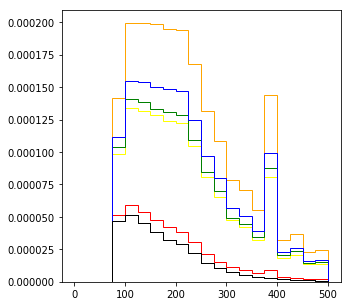

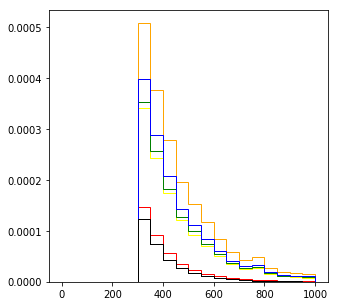

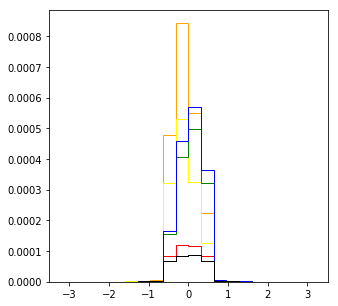

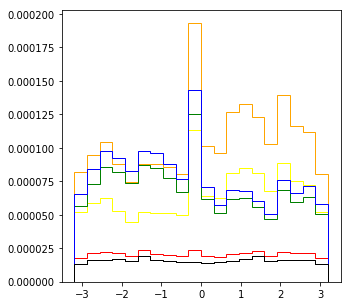

In [12]:
mycolors=["black","red","orange","yellow","green","blue","purple"]

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['phi_resurrection'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['phi_resurrection'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

### 3e) Combining Samples (if necessary) 

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [13]:
combine_and_shuffle(
    ['data/madminer_lhedata_0.h5'],
    'data/madminer_lhedata.h5'
)

09:35  Copying setup from data/madminer_lhedata_0.h5 to data/madminer_lhedata.h5
09:35  Loading samples from file 1 / 1 at data/madminer_lhedata_0.h5
